## Comparison of Similar Books recommendations

* Develop small utility to pull and display book images for similar books recommendations
* Gather the different representations of books for comparison
* Compare the methods on a handful of books that I know well enough to judge the quality of recommendations for

Methods:
1. NMF: non-negative matrix factorization on the book tags data
2. word2vec: implicit word2vec embeddings
3. MF50: explicit matrix factorization with 50 dimensions
4. MF100: explicit matrix factorization with 100 dimensions

In [1]:
import pandas as pd
import numpy as np

In [2]:
from gensim.models import Word2Vec

In [3]:
from numpy import dot
from numpy.linalg import norm

In [4]:
from operator import itemgetter

In [5]:
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup 

In [6]:
from matplotlib import pyplot as plt

In [22]:
from get_book_img import get_book_img

### Import books metadata

In [8]:
books = pd.read_csv('goodbooks-10k-master/books.csv')

In [9]:
books.head()

book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0                          The Hunger Games  ...       4780653   
1  Harry Potter and the Philosopher's Stone  ...       4602479   
2                                  Twilight  ...       3866839   
3                     To Kill a Mockingbird  ...       3198671   
4                          The Great Gatsby  ...       2683664   

  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  \
0            4942365                   155254      66715     127936   
1            4800065                    75867      75504     101676   
2            3916824                    95009     456191     436802   
3            3340896                    72586      60427     117415   
4            2773745                    51992      86236     197621   

   ratings_3  ratings_4  ratings_5  \
0     560092    1481305    2706317   
1     455024    1156318    3011543   
2     793319     875073    1355439   
3     446835    1001952    1714267   
4     606158     936012     947718   

                                           image_url  \
0  https://images.gr-assets.com/books/1447303603m...   
1  https://images.gr-assets.com/books/1474154022m...   
2  https://images.gr-assets.com/books/1361039443m...   
3  https://images.gr-assets.com/books/1361975680m...   
4  https://images.gr-assets.com/books/1490528560m...   

                                     small_image_url  
0  https://images.gr-assets.com/books/1447303603s...  
1  https://images.gr-assets.com/books/1474154022s...  
2  https://images.gr-assets.com/books/1361039443s...  
3  https://images.gr-assets.com/books/1361975680s...  
4  https://images.gr-assets.com/books/1490528560s...  

[5 rows x 23 columns]

In [10]:
books.columns

Index(['book_id', 'goodreads_book_id', 'best_book_id', 'work_id',
       'books_count', 'isbn', 'isbn13', 'authors', 'original_publication_year',
       'original_title', 'title', 'language_code', 'average_rating',
       'ratings_count', 'work_ratings_count', 'work_text_reviews_count',
       'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',
       'image_url', 'small_image_url'],
      dtype='object')

### Import embeddings

In [11]:
mf50_vectors = np.load('models/mf_book_vectors.npy')

In [12]:
mf100_vectors = np.load('models/mf_book_vectors_100.npy')

In [13]:
nmf_embeds =  np.load('models/tags_nmf.npy')

In [14]:
w2v_model = Word2Vec.load('models/gensim_sg_w2v')

In [15]:
nmf_embeds.shape

(10000, 300)

In [15]:
books.shape

(10000, 23)

### Develop necessary functions 
- get most similar books 
- display results

In [16]:
books[books['book_id']==1]['image_url'].values[0]

'https://images.gr-assets.com/books/1447303603m/2767052.jpg'

In [17]:
book_dict = {}
for i,row in books.iterrows():
    book_dict[row['book_id']] = {"title": row["title"]
                                 ,"goodreads_id":row["goodreads_book_id"]
                                 ,"image_url": row["image_url"]
                                 ,"authors":row["authors"]
                                 ,"mf50": mf50_vectors[row['book_id']]
                                 ,"mf100": mf100_vectors[row['book_id']]
                                 ,'nmf':nmf_embeds[row['book_id']-1]
                                 ,"w2v":w2v_model.wv[row["title"]]
                                }

In [18]:
def cosine_sim(a,b):
    return dot(a,b) / (norm(a)*norm(b))

In [19]:
def get_similar_books(book_i,bdict,nr_recs=5,embed='mf50'):
    bdict=book_dict
    embed_i = bdict[book_i][embed]
    sims = []
    for key,values in bdict.items():
        if key != book_i:
            embed_j = values[embed]
            sim_ij = cosine_sim(embed_i,embed_j)
            sims.append((key,sim_ij))
    sims.sort(key=itemgetter(1),reverse=True)
    return(sims[:nr_recs])

In [20]:
get_similar_books(7,book_dict)

[(19, 0.9388274),
 (189, 0.91790557),
 (964, 0.89563316),
 (155, 0.8786012),
 (161, 0.87253034)]

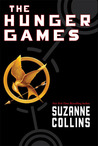

In [23]:
get_book_img(1,book_dict[1]["image_url"])

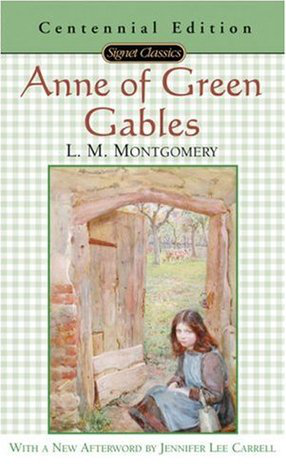

In [25]:
get_book_img(book_dict[133]["goodreads_id"],book_dict[133]["image_url"])

In [20]:
def rec_display(book_i,bdict,nr_recs=5,embed='mf50',query_img=True,rec_img=True):
    print(str(book_i)+": "+bdict[book_i]['title'])
    if query_img:
        img_i = get_book_img(book_dict[book_i]["goodreads_id"],book_dict[book_i]["image_url"])
        plt.figure(figsize=(6,4))
        plt.imshow(img_i)
        plt.show()
    print("Most similar:")
    recs = get_similar_books(book_i,bdict,nr_recs,embed)
    if rec_img:
        plt.figure(figsize=(10*np.ceil(nr_recs/5),12))
        for i,(book_j,sim) in enumerate(recs):
            img_j = get_book_img(book_dict[book_j]["goodreads_id"],book_dict[book_j]["image_url"])
            plt.subplot(np.ceil(nr_recs/5),5,i+1)
            #plt.title(str(book_j)+": "+bdict[book_j]['title'])
            plt.title(str(book_j))
            plt.imshow(img_j)
            print(str(i)+". "+str(book_j)+" "+bdict[book_j]['title'])
    else:
         for i,(book_j,sim) in enumerate(recs):
            print(str(i)+". "+str(book_j)+" "+bdict[book_j]['title'])

### Most popular book in dataset: Hunger Games #1

1: The Hunger Games (The Hunger Games, #1)


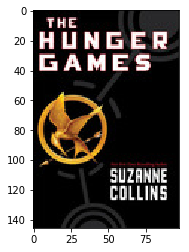

Most similar:
0. 20 Mockingjay (The Hunger Games, #3)
1. 507 The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)
2. 6214 The Divergent Series 2-Book Collection (Divergent, #1-2)
3. 3777 Fear (Gone, #5)
4. 4751 Light (Gone, #6)


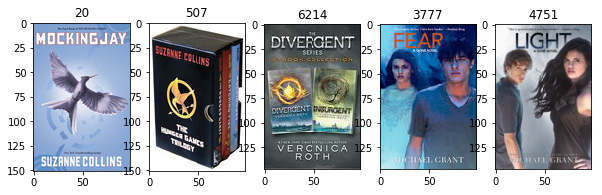

In [29]:
rec_display(1,book_dict,5,'nmf')

1: The Hunger Games (The Hunger Games, #1)
Most similar:
0. 51 City of Bones (The Mortal Instruments, #1)
1. 12 Divergent (Divergent, #1)
2. 3 Twilight (Twilight, #1)
3. 6224 The World of the Hunger Games (Hunger Games Trilogy)
4. 41 The Lightning Thief (Percy Jackson and the Olympians, #1)


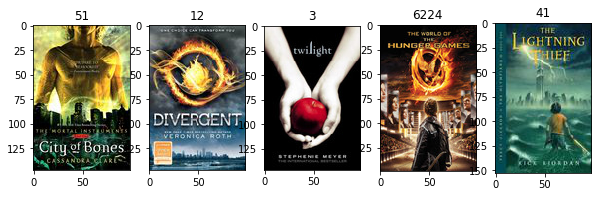

In [60]:
rec_display(1,book_dict,5,'w2v',query_img=False)

1: The Hunger Games (The Hunger Games, #1)
Most similar:
0. 17 Catching Fire (The Hunger Games, #2)
1. 20 Mockingjay (The Hunger Games, #3)
2. 507 The Hunger Games Trilogy Boxset (The Hunger Games, #1-3)
3. 12 Divergent (Divergent, #1)
4. 31 The Help


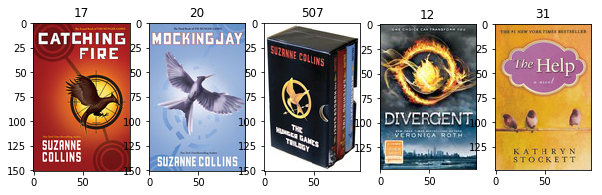

In [61]:
rec_display(1,book_dict,5,'mf50',query_img=False)

1: The Hunger Games (The Hunger Games, #1)
Most similar:
0. 17 Catching Fire (The Hunger Games, #2)
1. 20 Mockingjay (The Hunger Games, #3)
2. 31 The Help
3. 2 Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
4. 25 Harry Potter and the Deathly Hallows (Harry Potter, #7)


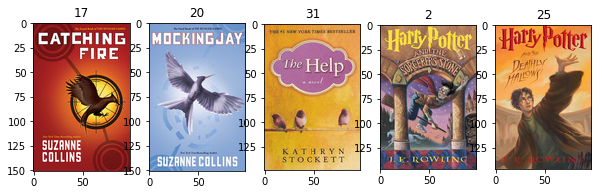

In [62]:
rec_display(1,book_dict,5,'mf100',query_img=False)

### The Return of the King
LOTR is my favorite

161: The Return of the King (The Lord of the Rings, #3)


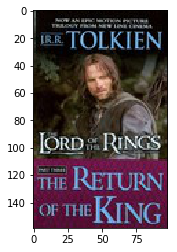

Most similar:
0. 155 The Two Towers (The Lord of the Rings, #2)
1. 1964 Fool's Errand (Tawny Man, #1)
2. 7325 Rhapsody: Child of Blood (Symphony of Ages, #1)
3. 6653 Elric of Melniboné (Elric, #1)
4. 2269 Magician (The Riftwar Saga, #1-2)


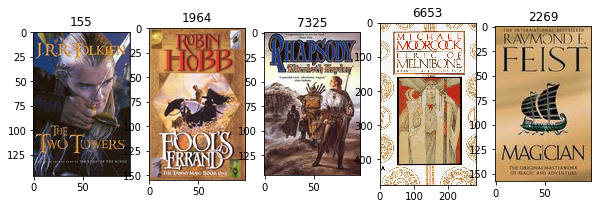

In [30]:
rec_display(161,book_dict,5,'nmf')

161: The Return of the King (The Lord of the Rings, #3)
Most similar:
0. 155 The Two Towers (The Lord of the Rings, #2)
1. 611 The Silmarillion (Middle-Earth Universe)
2. 2309 The Children of Húrin
3. 4976 Unfinished Tales of Númenor and Middle-Earth
4. 189 The Lord of the Rings (The Lord of the Rings, #1-3)


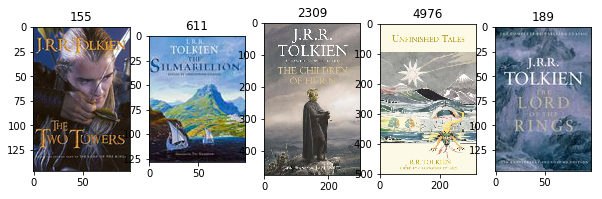

In [31]:
rec_display(161,book_dict,5,'w2v',query_img=False)

161: The Return of the King (The Lord of the Rings, #3)
Most similar:
0. 155 The Two Towers (The Lord of the Rings, #2)
1. 189 The Lord of the Rings (The Lord of the Rings, #1-3)
2. 19 The Fellowship of the Ring (The Lord of the Rings, #1)
3. 964 J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings
4. 7 The Hobbit


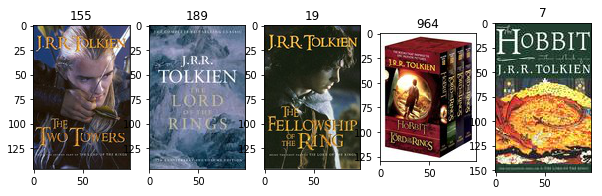

In [65]:
rec_display(161,book_dict,5,'mf50',query_img=False)

161: The Return of the King (The Lord of the Rings, #3)
Most similar:
0. 155 The Two Towers (The Lord of the Rings, #2)
1. 19 The Fellowship of the Ring (The Lord of the Rings, #1)
2. 189 The Lord of the Rings (The Lord of the Rings, #1-3)
3. 7 The Hobbit
4. 466 The Hobbit: Graphic Novel


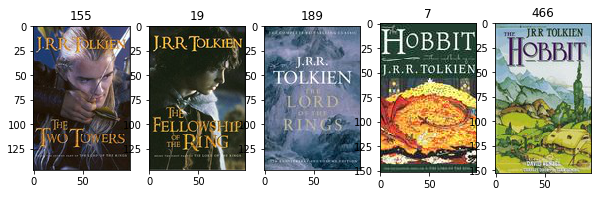

In [66]:
rec_display(161,book_dict,5,'mf100',query_img=False)

### Checking some Classics that I like

#### Dracula

97: Dracula


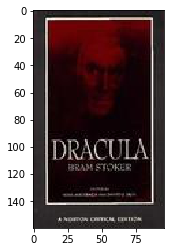

Most similar:
0. 95 The Picture of Dorian Gray
1. 83 A Tale of Two Cities
2. 390 The Strange Case of Dr. Jekyll and Mr. Hyde
3. 42 Little Women (Little Women, #1)
4. 194 Moby-Dick or, The Whale


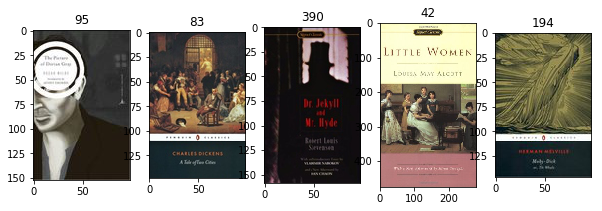

In [32]:
rec_display(97,book_dict,5,'nmf')

97: Dracula
Most similar:
0. 95 The Picture of Dorian Gray
1. 103 The Count of Monte Cristo
2. 171 Emma
3. 71 Frankenstein
4. 160 Great Expectations


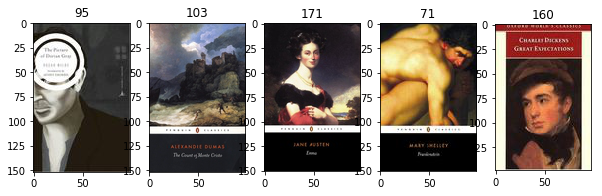

In [143]:
rec_display(97,book_dict,5,'w2v',query_img=False)

97: Dracula
Most similar:
0. 71 Frankenstein
1. 390 The Strange Case of Dr. Jekyll and Mr. Hyde
2. 512 The Complete Stories and Poems
3. 116 The Adventures of Tom Sawyer
4. 9648 Soul on Ice


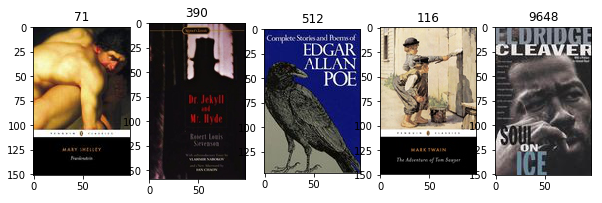

In [144]:
rec_display(97,book_dict,5,'mf50',query_img=False)

97: Dracula
Most similar:
0. 19 The Fellowship of the Ring (The Lord of the Rings, #1)
1. 71 Frankenstein
2. 390 The Strange Case of Dr. Jekyll and Mr. Hyde
3. 155 The Two Towers (The Lord of the Rings, #2)
4. 547 The War of the Worlds


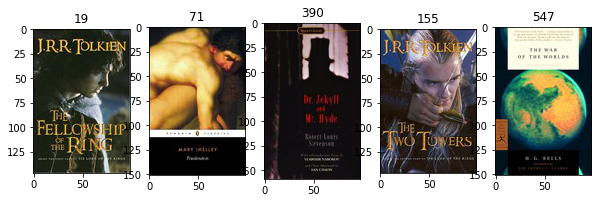

In [145]:
rec_display(97,book_dict,5,'mf100',query_img=False)

#### Pride and Prejudice

10: Pride and Prejudice


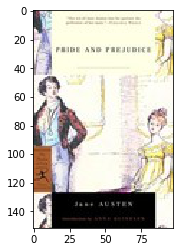

Most similar:
0. 5 The Great Gatsby
1. 63 Wuthering Heights
2. 103 The Count of Monte Cristo
3. 559 Tess of the D'Urbervilles
4. 8 The Catcher in the Rye


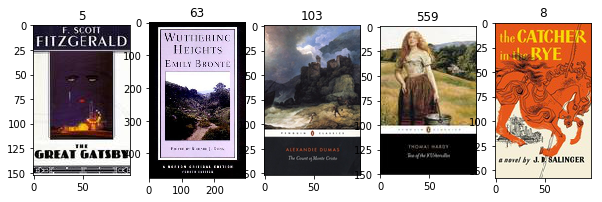

In [33]:
rec_display(10,book_dict,5,'nmf')

10: Pride and Prejudice
Most similar:
0. 43 Jane Eyre
1. 63 Wuthering Heights
2. 9479 Manga Classics: Les Misérables
3. 6948 Sense & Sensibility (The Austen Project, #1)
4. 4870 Shirley


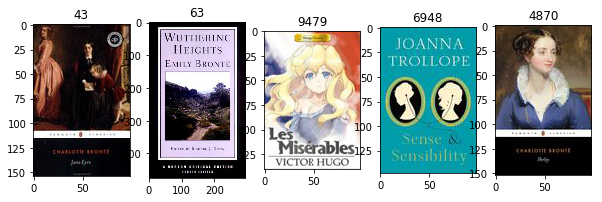

In [34]:
rec_display(10,book_dict,5,'w2v',query_img=False)

10: Pride and Prejudice
Most similar:
0. 76 Sense and Sensibility
1. 171 Emma
2. 43 Jane Eyre
3. 42 Little Women (Little Women, #1)
4. 4653 The Complete Novels


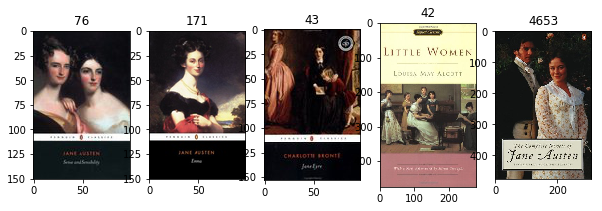

In [35]:
rec_display(10,book_dict,5,'mf50',query_img=False)

10: Pride and Prejudice
Most similar:
0. 76 Sense and Sensibility
1. 42 Little Women (Little Women, #1)
2. 43 Jane Eyre
3. 4 To Kill a Mockingbird
4. 133 Anne of Green Gables (Anne of Green Gables, #1)


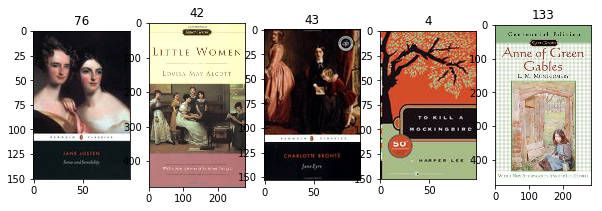

In [36]:
rec_display(10,book_dict,5,'mf100',query_img=False)

#### Wuthering Heights

63: Wuthering Heights
Most similar:
0. 559 Tess of the D'Urbervilles
1. 2499 Villette
2. 10 Pride and Prejudice
3. 590 David Copperfield
4. 9455 The Old Curiosity Shop


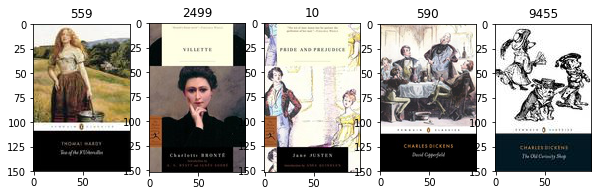

In [76]:
rec_display(63,book_dict,5,'nmf',query_img=False)

63: Wuthering Heights
Most similar:
0. 76 Sense and Sensibility
1. 43 Jane Eyre
2. 1073 Vanity Fair
3. 42 Little Women (Little Women, #1)
4. 172 Anna Karenina


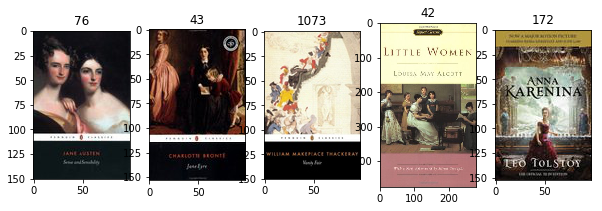

In [37]:
rec_display(63,book_dict,5,'w2v',query_img=False)

63: Wuthering Heights
Most similar:
0. 43 Jane Eyre
1. 559 Tess of the D'Urbervilles
2. 172 Anna Karenina
3. 29 Romeo and Juliet
4. 1088 Far from the Madding Crowd


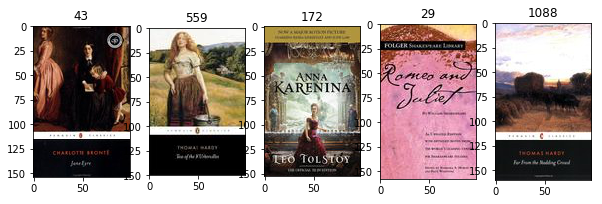

In [78]:
rec_display(63,book_dict,5,'mf50',query_img=False)

63: Wuthering Heights
Most similar:
0. 43 Jane Eyre
1. 29 Romeo and Juliet
2. 138 The Scarlet Letter
3. 899 The Age of Innocence
4. 231 Sarah's Key


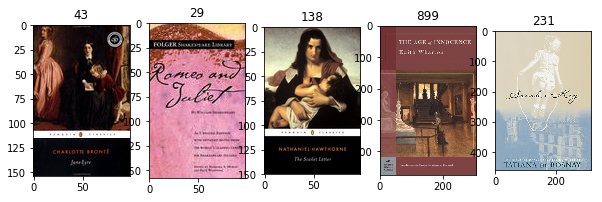

In [38]:
rec_display(63,book_dict,5,'mf100',query_img=False)

#### Anne of Green Gables

133: Anne of Green Gables (Anne of Green Gables, #1)
Most similar:
0. 5567 Rainbow Valley (Anne of Green Gables, #7)
1. 7430 Rose in Bloom (Eight Cousins, #2)
2. 1112 Anne of the Island (Anne of Green Gables, #3)
3. 3138 Anne of Windy Poplars (Anne of Green Gables, #4)
4. 8591 Emily Climbs (Emily, #2)


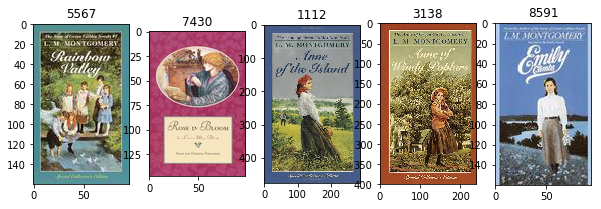

In [39]:
rec_display(133,book_dict,5,'nmf',query_img=False)

133: Anne of Green Gables (Anne of Green Gables, #1)
Most similar:
0. 93 The Secret Garden
1. 2324 By the Shores of Silver Lake  (Little House, #5)
2. 4014 Emily of New Moon (Emily, #1)
3. 444 Winnie-the-Pooh (Winnie-the-Pooh, #1)
4. 540 A Little Princess


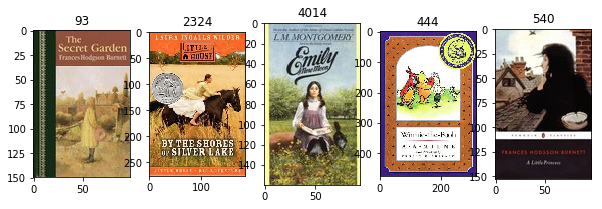

In [40]:
rec_display(133,book_dict,5,'w2v',query_img=False)

133: Anne of Green Gables (Anne of Green Gables, #1)
Most similar:
0. 958 The Complete Anne of Green Gables Boxed Set (Anne of Green Gables, #1-8)
1. 1210 Anne of Avonlea (Anne of Green Gables, #2)
2. 681 Little House in the Big Woods (Little House, #1)
3. 544 Little House on the Prairie (Little House, #2)
4. 265 A Tree Grows in Brooklyn


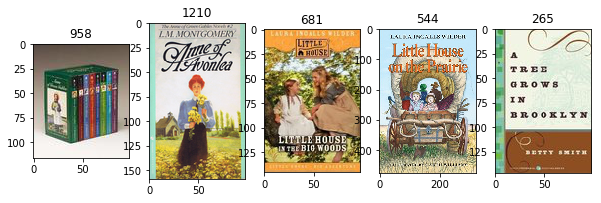

In [41]:
rec_display(133,book_dict,5,'mf50',query_img=False)

133: Anne of Green Gables (Anne of Green Gables, #1)
Most similar:
0. 93 The Secret Garden
1. 4 To Kill a Mockingbird
2. 66 Gone with the Wind
3. 195 The Guernsey Literary and Potato Peel Pie Society
4. 43 Jane Eyre


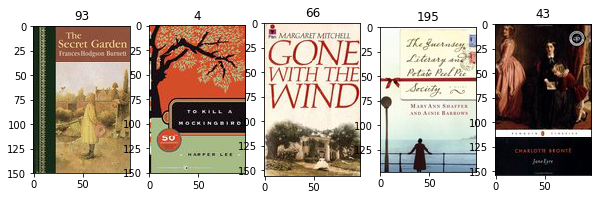

In [83]:
rec_display(133,book_dict,5,'mf100',query_img=False)

### Checking some more obscure titles

#### Carmilla- Sheridan Le Fanu's vampire novella, pre-dated and inspired Bram Stoker

5581: Carmilla


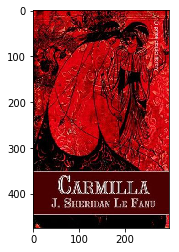

Most similar:
0. 2637 We Have Always Lived in the Castle
1. 3773 The Woman in Black
2. 6278 Jamaica Inn
3. 97 Dracula
4. 390 The Strange Case of Dr. Jekyll and Mr. Hyde


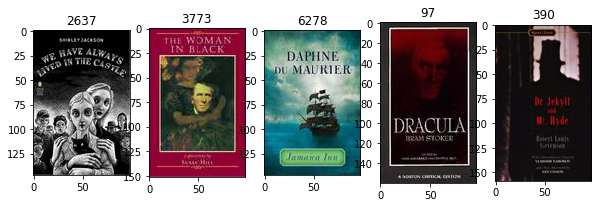

In [25]:
rec_display(5581,book_dict,5,'nmf')

5581: Carmilla
Most similar:
0. 7176 The Monk
1. 7667 Lost Souls
2. 9058 Shadows over Innsmouth
3. 8162 The Castle of Otranto
4. 4859 Books of Blood: Volumes One to Three (Books of Blood #1-3)


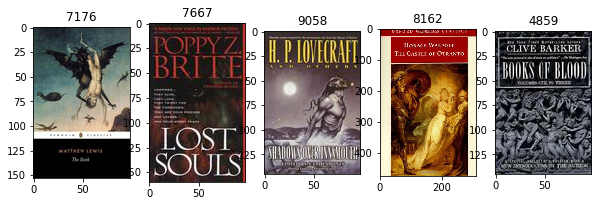

In [42]:
rec_display(5581,book_dict,5,'w2v',query_img=False)

5581: Carmilla
Most similar:
0. 8422 The Devil's Punchbowl
1. 7822 Riptide
2. 2245 The Enemy (Jack Reacher, #8)
3. 4050 When Things Fall Apart: Heart Advice for Difficult Times
4. 2150 Body of Evidence (Kay Scarpetta, #2)


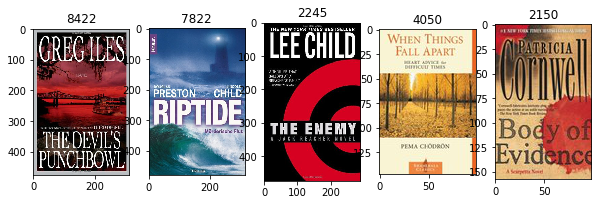

In [43]:
rec_display(5581,book_dict,5,'mf50',query_img=False)

In [167]:
rec_display(5581,book_dict,5,'mf100',query_img=False,rec_img=False)

5581: Carmilla
Most similar:
0. 3969 Planet of the Apes
1. 4701 The Fog
2. 1380 The Complete Maus (Maus, #1-2)
3. 2064 The Miraculous Journey of Edward Tulane
4. 1531 Gregor the Overlander (Underland Chronicles, #1)


In [153]:
books[books['book_id']==5581][['book_id','title','authors']]

book_id     title              authors
5580     5581  Carmilla  J. Sheridan Le Fanu

#### Morbid Taste for Bones - Medieval themed mystery

In [158]:
books[books['authors'] == "Ellis Peters"][['book_id','title','authors']]

book_id                                              title       authors
4778     4779  A Morbid Taste for Bones (Chronicles of Brothe...  Ellis Peters

4779: A Morbid Taste for Bones (Chronicles of Brother Cadfael, #1)


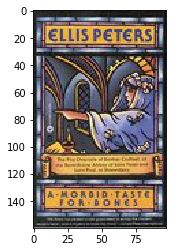

Most similar:
0. 3958 When Will There Be Good News? (Jackson Brodie, #3)
1. 9635 Mystery (Alex Delaware, #26)
2. 6992 Think of a Number (Dave Gurney, #1)
3. 9059 The Tin Roof Blowdown (Dave Robicheaux, #16)
4. 9510 Among the Mad (Maisie Dobbs, #6)


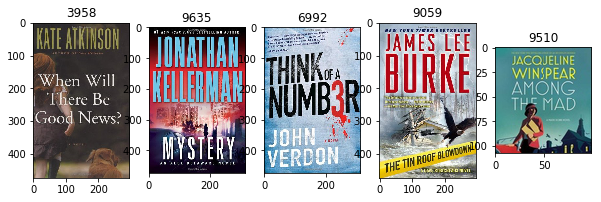

In [44]:
rec_display(4779,book_dict,5,'nmf',query_img=True)

4779: A Morbid Taste for Bones (Chronicles of Brother Cadfael, #1)
Most similar:
0. 4290 Whose Body?  (Lord Peter Wimsey, #1)
1. 5777 An Instance of the Fingerpost
2. 7855 Murder Must Advertise  (Lord Peter Wimsey, #10)
3. 4586 Cover Her Face (Adam Dalgliesh #1)
4. 6853 The Unexpected Mrs. Pollifax  (Mrs. Pollifax #1)


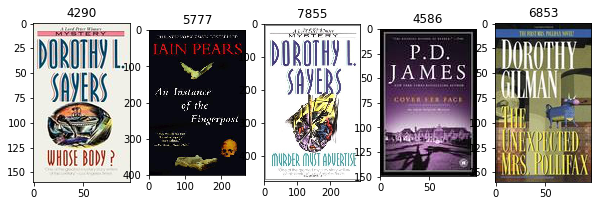

In [45]:
rec_display(4779,book_dict,5,'w2v',query_img=False)

4779: A Morbid Taste for Bones (Chronicles of Brother Cadfael, #1)
Most similar:
0. 7911 Divided in Death (In Death, #18)
1. 6844 Moon Palace
2. 7748 Nemesis (Miss Marple, #12)
3. 1114 North and South
4. 7633 Born in Death (In Death, #23)


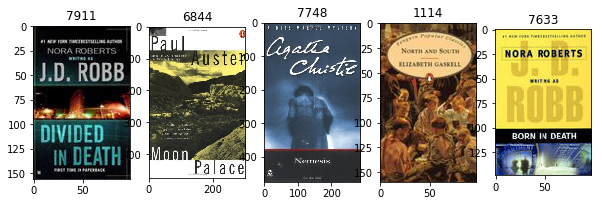

In [46]:
rec_display(4779,book_dict,5,'mf50',query_img=False)

4779: A Morbid Taste for Bones (Chronicles of Brother Cadfael, #1)
Most similar:
0. 362 The Screwtape Letters
1. 9084 The Greatest Generation
2. 70 Ender's Game (Ender's Saga, #1)
3. 3670 Cibola Burn (The Expanse, #4)
4. 780 Calvin and Hobbes


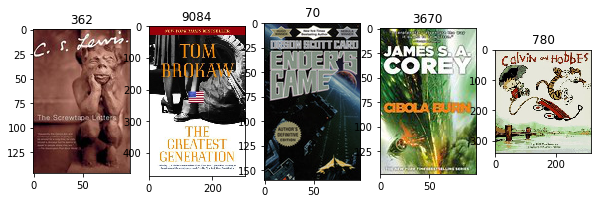

In [47]:
rec_display(4779,book_dict,5,'mf100',query_img=False)

### Michael Pollan's Food Rules

In [172]:
books[books['authors']=='Michael Pollan'][['book_id','title','authors']]

book_id                                              title  \
549       550  The Omnivore's Dilemma: A Natural History of F...   
1059     1060           In Defense of Food: An Eater's Manifesto   
2356     2357  The Botany of Desire: A Plant's-Eye View of th...   
3286     3287                      Food Rules: An Eater's Manual   
5285     5286        Cooked: A Natural History of Transformation   

             authors  
549   Michael Pollan  
1059  Michael Pollan  
2356  Michael Pollan  
3286  Michael Pollan  
5285  Michael Pollan

3287: Food Rules: An Eater's Manual
Most similar:
0. 1060 In Defense of Food: An Eater's Manifesto
1. 4843 Salt Sugar Fat: How the Food Giants Hooked Us
2. 5070 The China Study: The Most Comprehensive Study of Nutrition Ever Conducted And the Startling Implications for Diet, Weight Loss, And Long-term Health
3. 6609 Why We Get Fat: And What to Do About It
4. 4394 Heat: An Amateur's Adventures as Kitchen Slave, Line Cook, Pasta-Maker, and Apprentice to a Dante-Quoting Butcher in Tuscany


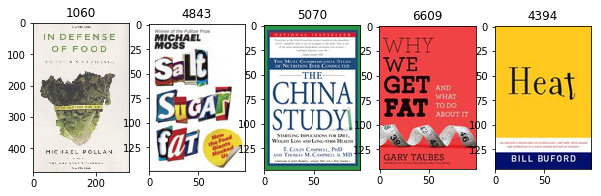

In [48]:
rec_display(3287,book_dict,5,'nmf',query_img=False)

3287: Food Rules: An Eater's Manual
Most similar:
0. 8463 Food Matters: A Guide to Conscious Eating with More Than 75 Recipes
1. 7518 The Art of Simple Food: Notes, Lessons, and Recipes from a Delicious Revolution
2. 9934 Nourishing Traditions: The Cookbook That Challenges Politically Correct Nutrition and the Diet Dictocrats
3. 1060 In Defense of Food: An Eater's Manifesto
4. 6988 How to Cook Everything Vegetarian: Simple Meatless Recipes for Great Food


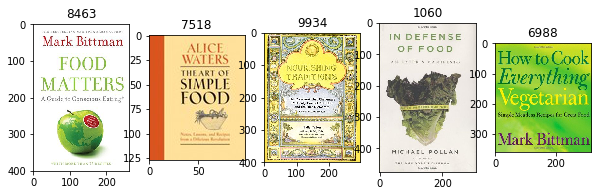

In [49]:
rec_display(3287,book_dict,5,'w2v',query_img=False)

3287: Food Rules: An Eater's Manual
Most similar:
0. 6348 All I Really Need to Know I Learned in Kindergarten
1. 3954 Hunger
2. 7923 An Anthropologist on Mars: Seven Paradoxical Tales
3. 2636 Destiny of the Republic: A Tale of Madness, Medicine and the Murder of a President
4. 4016 Grendel


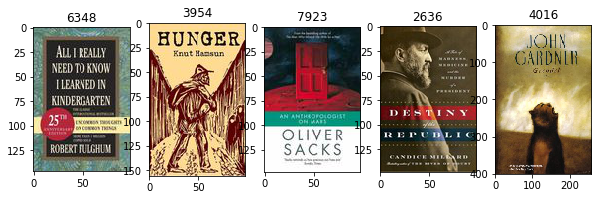

In [50]:
rec_display(3287,book_dict,5,'mf50',query_img=False)

3287: Food Rules: An Eater's Manual
Most similar:
0. 313 The Light Between Oceans
1. 1023 Lord of Chaos (Wheel of Time, #6)
2. 364 How the Grinch Stole Christmas!
3. 3484 A Modest Proposal
4. 549 Corduroy


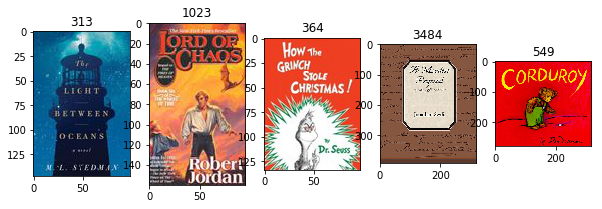

In [51]:
rec_display(3287,book_dict,5,'mf100',query_img=False)

#### Sample some books and choose a low ranked one to test on

In [118]:
books[books['book_id']>6000].sample(5)[['book_id','title','authors']]

book_id                                              title  \
6415     6416                Sweet Filthy Boy (Wild Seasons, #1)   
9353     9354        Darth Paper Strikes Back (Origami Yoda, #2)   
8824     8825                               The Color of Secrets   
8056     8057                               Absent In The Spring   
6484     6485  The Drunkard's Walk: How Randomness Rules Our ...   

                               authors  
6415                  Christina Lauren  
9353                   Tom Angleberger  
8824                   Lindsay Ashford  
8056  Mary Westmacott, Agatha Christie  
6484                  Leonard Mlodinow

#### Picking one I recognize
The Drunkard's Walk, which is statistics/math themed pop sci nonfiction

6485: The Drunkard's Walk: How Randomness Rules Our Lives
Most similar:
0. 3227 The Signal and the Noise: Why So Many Predictions Fail - But Some Don't
1. 7923 An Anthropologist on Mars: Seven Paradoxical Tales
2. 881 The Man Who Mistook His Wife for a Hat and Other Clinical Tales
3. 2661 Bonk: The Curious Coupling of Science and Sex
4. 8000 The Red Queen: Sex and the Evolution of Human Nature


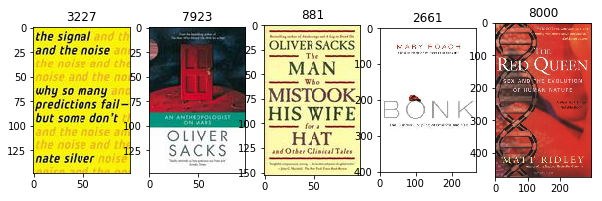

In [52]:
rec_display(6485,book_dict,5,'nmf',query_img=False)

6485: The Drunkard's Walk: How Randomness Rules Our Lives
Most similar:
0. 4417 The Upside of Irrationality: The Unexpected Benefits of Defying Logic at Work and at Home
1. 9939 Where Good Ideas Come From: The Natural History of Innovation
2. 5761 Mistakes Were Made (But Not by Me): Why We Justify Foolish Beliefs, Bad Decisions, and Hurtful Acts
3. 9878 The Honest Truth About Dishonesty: How We Lie to Everyone - Especially Ourselves
4. 7111 Talent is Overrated: What Really Separates World-Class Performers from Everybody Else


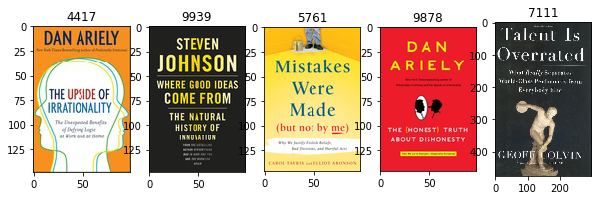

In [53]:
rec_display(6485,book_dict,5,'w2v',query_img=False)

In [141]:
rec_display(6485,book_dict,5,'mf50',query_img=False,rec_img=False)

6485: The Drunkard's Walk: How Randomness Rules Our Lives
Most similar:
0. 9563 The Society of the Spectacle
1. 1420 The Rise and Fall of the Third Reich: A History of Nazi Germany
2. 5369 Memories, Dreams, Reflections
3. 9504 The Obelisk Gate (The Broken Earth, #2)
4. 4806 The Bonehunters (Malazan Book of the Fallen, #6)


6485: The Drunkard's Walk: How Randomness Rules Our Lives
Most similar:
0. 4420 Natchez Burning
1. 129 One Flew Over the Cuckoo's Nest
2. 128 Steve Jobs
3. 190 Wild: From Lost to Found on the Pacific Crest Trail
4. 1479 Furies of Calderon (Codex Alera, #1)


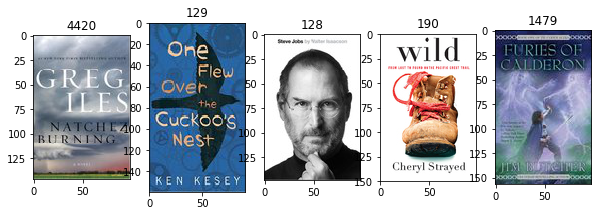

In [122]:
rec_display(6485,book_dict,5,'mf100',query_img=False)

### Some conclusions

Based on these qualitative comparisons,
* the 100-dim MF solution is not a good as the 50-dim version (test set MSE was also worse)
* MF seems to do extremely well for the most popular books, but very poorly for long tail books
* word2vec and NMF still make reasonable recs for long tail books
* NMF tends to give unique recs in the same topic or genre, but sometimes agrees with word2vec
* Overall word2vec seems to be best across the board